# EDA

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import pickle
import os

# fix random seed
seed = 0
random.seed(seed)
np.random.seed(seed)

/home/lichang/.virtualenvs/py38/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
train = pd.read_csv("./data/raw_data/train.csv")
test = pd.read_csv("./data/raw_data/test.csv")
sample = pd.read_csv("./data/raw_data/sample_submission.csv")

In [3]:
train.head()

,ID,review,sentiment
0,41411,I watched this film because I'm a big fan of R...,0
1,37586,It does not seem that this movie managed to pl...,1
2,6017,"Enough is not a bad movie , just mediocre .",0
3,44656,my friend and i rented this one a few nights a...,0
4,38711,"Just about everything in this movie is wrong, ...",0


In [4]:
train.isnull().sum()

ID           0
review       0
sentiment    0
dtype: int64

In [5]:
test.head()

,ID,review
0,22622,Robert Lansing plays a scientist experimenting...
1,10162,"Well I've enjoy this movie, even though someti..."
2,17468,First things first - though I believe Joel Sch...
3,42579,I watched this movie on the grounds that Amber...
4,701,A certain sexiness underlines even the dullest...


In [6]:
test.isnull().sum()

ID        0
review    0
dtype: int64

In [7]:
sample.head()

,ID,sentiment
0,22622,1
1,10162,1
2,17468,1
3,42579,1
4,701,1


In [8]:
sample.isnull().sum()

ID           0
sentiment    0
dtype: int64

## EDA

In [9]:
print("train data:", len(train))
print("test data:", len(test))

train data: 29341
test data: 29341


In [10]:
print("Positive data:", len(train[train["sentiment"] == 1]))
print("Negative data:", len(train[train["sentiment"] == 0]))

Positive data: 14954
Negative data: 14387


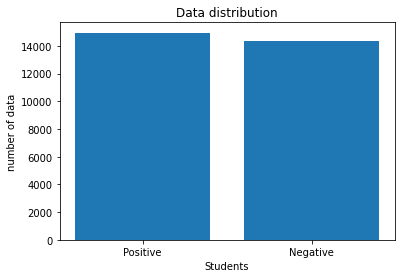

In [11]:
x_axis_label = ["Positive", "Negative"]
num_data = [len(train[train["sentiment"] == 1]), len(train[train["sentiment"] == 0])]
x = np.arange(len(x_axis_label))
plt.bar(x, num_data)
plt.xticks(x, x_axis_label)
plt.xlabel("Students")
plt.ylabel("number of data")
plt.title("Data distribution")
plt.show()

### average length

In [12]:
len_list = []
for i in range(len(train)):
    _, review, _ = train.iloc[i]
    if "<br />" in review:
        review_new = re.sub("<br />", " ", review)
        review_new = review_new.strip().split()
    else:
        review_new = review.strip().split()

    len_list.append(len(review_new))

In [13]:
print("mean: {:<5.2f}".format(np.mean(len_list)))
print("max : {:<5.2f}".format(np.max(len_list)))
print("min : {:<5.2f}".format(np.min(len_list)))
print("std : {:<5.2f}".format(np.std(len_list)))

mean: 196.84
max : 2088.00
min : 2.00 
std : 171.53


### remove `<br />` character

In [14]:
# train_rm_br = train.copy()
# test_rm_br = test.copy()

# # train
# for i in range(len(train_rm_br)):
#     _, review, _ = train_rm_br.iloc[i]
#     if "<br />" in review:
#         review_new = re.sub("<br />", " ", review)
#         review_new = " ".join(review_new.strip().split())
#     else:
#         review_new = " ".join(review.strip().split())
#     train_rm_br.loc[i, "review"] = review_new

# # test
# for i in range(len(test_rm_br)):
#     _, review = test_rm_br.iloc[i]
#     if "<br />" in review:
#         review_new = re.sub("<br />", " ", review)
#         review_new = " ".join(review_new.strip().split())
#     else:
#         review_new = " ".join(review.strip().split())
#     test_rm_br.loc[i, "review"] = review_new

# train_rm_br.to_pickle("./data/train_rm_br.pkl")
# test_rm_br.to_pickle("./data/test_rm_br.pkl")

In [15]:
train_rm_br = pd.read_pickle("./data/train_rm_br.pkl")
test_rm_br = pd.read_pickle("./data/test_rm_br.pkl")

In [16]:
print(
    "Same perenctage: {:.4f}".format(
        sum(train_rm_br["review"] == train["review"]) / len(train_rm_br["review"])
    )
)

Same perenctage: 0.4997


In [17]:
print(
    "Same perenctage: {:.4f}".format(
        sum(test_rm_br["review"] == test["review"]) / len(test_rm_br["review"])
    )
)

Same perenctage: 0.4991


In [18]:
train_rm_br == train

,ID,review,sentiment
0,True,True,True
1,True,False,True
2,True,True,True
3,True,True,True
4,True,True,True
...,...,...,...
29336,True,True,True
29337,True,True,True
29338,True,False,True
29339,True,False,True


In [19]:
test_rm_br == test

,ID,review
0,True,False
1,True,False
2,True,False
3,True,False
4,True,True
...,...,...
29336,True,False
29337,True,True
29338,True,True
29339,True,True


### Data leakage

In [61]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [30]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [22]:
def tokenizing(sent_list, sent_label, tokenizer):
    """
    Main tokenizing process.
    """

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids_list = []
    attention_masks_list = []
    # For every sentence...
    for sent in sent_list:
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=400,  # 512,  # Pad & truncate all sentences.
            padding="max_length",
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors="pt",  # Return pytorch tensors.
            truncation=True,
        )

        # Add the encoded sentence to the list.
        input_ids_list.append(encoded_dict["input_ids"])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_list.append(encoded_dict["attention_mask"])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids_list, dim=0)
    attention_masks = torch.cat(attention_masks_list, dim=0)
    if sent_label is not None:
        labels = torch.tensor(sent_label)
    else:
        labels = None

    return input_ids, attention_masks, labels

In [23]:
input_ids, attention_masks, _ = tokenizing(test.review.values, None, tokenizer)

In [28]:
# dataset
dataset = TensorDataset(input_ids, attention_masks)
data_loader = DataLoader(dataset, shuffle=False, batch_size=8)

In [32]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained(
    "bert-base-uncased",
    output_hidden_states=True,  # Whether the model returns all hidden-states.
)

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [50]:
embeding_list = []
with torch.no_grad():
    for batch in data_loader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        outputs = model(b_input_ids, b_input_mask)
        word_embedding = outputs[0][:, 0, :].cpu().numpy()
        embeding_list.extend(word_embedding)
#         print("last_hidden_state:", outputs[0].shape)
#         print("word_embedding:", word_embedding.shape)

In [51]:
len(embeding_list)

29341

In [52]:
df = test_rm_br.copy()

In [53]:
df["word_embedding"] = embeding_list

In [57]:
df

,ID,review,word_embedding
0,22622,Robert Lansing plays a scientist experimenting...,"[0.19319223, -0.23533346, -0.11448899, -0.1030..."
1,10162,"Well I've enjoy this movie, even though someti...","[-0.009197136, -0.19855839, 0.1142654, -0.1513..."
2,17468,First things first - though I believe Joel Sch...,"[-0.37200502, -0.4342512, -0.18357867, -0.0142..."
3,42579,I watched this movie on the grounds that Amber...,"[-0.009973719, -0.022616692, 0.101972125, -0.2..."
4,701,A certain sexiness underlines even the dullest...,"[0.0035906716, 0.14114958, -0.49467295, 0.2219..."
...,...,...,...
29336,30370,It is difficult to rate a writer/director's fi...,"[0.098918095, -0.46373388, 0.19135708, -0.0207..."
29337,18654,"After watching this movie once, it quickly bec...","[0.21501364, -0.23446126, 0.2605786, -0.406986..."
29338,47985,"Even though i sat and watched the whole thing,...","[-0.0183749, -0.4181855, 0.4547821, -0.3024411..."
29339,9866,Warning Spoilers following. Superb recreation ...,"[-0.44533634, -0.2653322, -0.21847115, -0.1641..."


In [76]:
correlation_matrix = np.corrcoef(np.array(embeding_list))

In [77]:
correlation_matrix.shape

(29341, 29341)

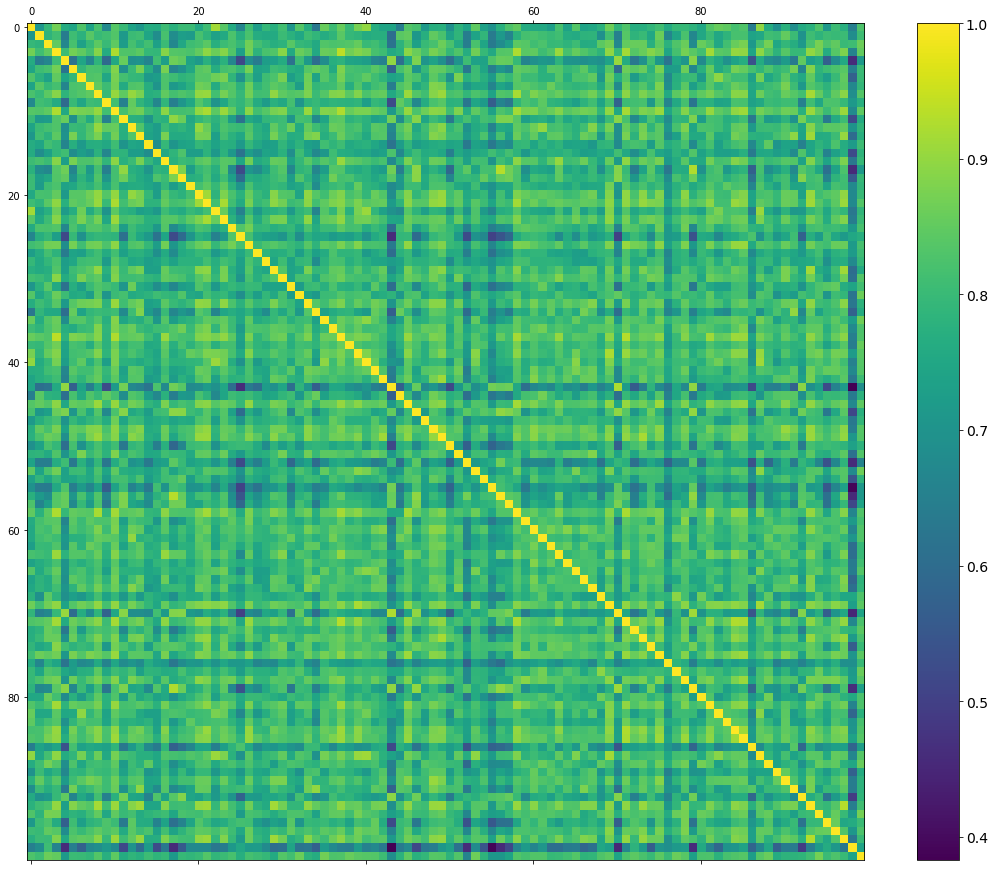

In [94]:
f = plt.figure(figsize=(19, 15))
plt.matshow(correlation_matrix[:100, :100], fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [96]:
correlation_matrix

(29341, 29341)

In [98]:
cm_flatten = correlation_matrix.reshape(
    -1,
)

In [99]:
cm_flatten.shape

(860894281,)

In [102]:
cm_qni_val = np.unique(cm_flatten)

In [106]:
cm_qni_val[:5]

array([0.04700922, 0.04700922, 0.05024383, 0.09957466, 0.09957466])

In [107]:
pred = cm_qni_val > 0.5

## Train / test split

In [20]:
X = train_rm_br["review"]
y = train_rm_br["sentiment"]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### check data balance

In [22]:
print("Training set:", len(X_train))
print("Test set:", len(X_test))
print()
print("Training POS data:", sum(y_train == 1))
print("Training NEG data:", sum(y_train == 0))
print("-" * 20)
print("Test POS data:", sum(y_test == 1))
print("Test NEG data:", sum(y_test == 0))
print("-" * 20)
print(
    "Total:",
    sum(y_train == 1) + sum(y_train == 0) + sum(y_test == 1) + sum(y_test == 0),
)

Training set: 23472
Test set: 5869

Training POS data: 11960
Training NEG data: 11512
--------------------
Test POS data: 2994
Test NEG data: 2875
--------------------
Total: 29341


In [23]:
path = "./data/train_test_split"
if not os.path.isdir(path):
    os.mkdir(path)
X_train.to_pickle(os.path.join(path, "./X_tr.pkl"))
X_test.to_pickle(os.path.join(path, "./X_te.pkl"))
y_train.to_pickle(os.path.join(path, "./y_tr.pkl"))
y_test.to_pickle(os.path.join(path, "./y_te.pkl"))

## Train / Validation split (Holdout)

![holdout](./pics/holdout.png)

**Holdout:** Level 1 and Level 2 data split, 10% holdout.

In [24]:
X_l1, X_l2, y_l1, y_l2 = train_test_split(
    X_train, y_train, test_size=0.1, random_state=0
)

### check data balance

In [25]:
print("Level 1:", len(y_l1))
print("Level 2:", len(y_l2))
print()
print("Training POS data:", sum(y_l1 == 1))
print("Training NEG data:", sum(y_l1 == 0))
print("-" * 20)
print("Test POS data:", sum(y_l2 == 1))
print("Test NEG data:", sum(y_l2 == 0))
print("-" * 20)
print(
    "Total:",
    sum(y_l1 == 1) + sum(y_l1 == 0) + sum(y_l2 == 1) + sum(y_l2 == 0),
)

Level 1: 21124
Level 2: 2348

Training POS data: 10725
Training NEG data: 10399
--------------------
Test POS data: 1235
Test NEG data: 1113
--------------------
Total: 23472


**Holdout:** Level 1 data split, 10% holdout.

In [26]:
X_tr_l1, X_va_l1, y_tr_l1, y_va_l1 = train_test_split(
    X_l1, y_l1, test_size=0.1, random_state=0
)

In [27]:
print("Level 1 Train:", len(y_tr_l1))
print("Level 1 valid:", len(y_va_l1))
print()
print("Training POS data:", sum(y_tr_l1 == 1))
print("Training NEG data:", sum(y_tr_l1 == 0))
print("-" * 20)
print("Test POS data:", sum(y_va_l1 == 1))
print("Test NEG data:", sum(y_va_l1 == 0))
print("-" * 20)
print(
    "Total:",
    sum(y_tr_l1 == 1) + sum(y_tr_l1 == 0) + sum(y_va_l1 == 1) + sum(y_va_l1 == 0),
)

Level 1 Train: 19011
Level 1 valid: 2113

Training POS data: 9625
Training NEG data: 9386
--------------------
Test POS data: 1100
Test NEG data: 1013
--------------------
Total: 21124


In [33]:
path = "./data/train_valid_split/"
if not os.path.isdir(path):
    os.mkdir(path)

path_l1 = "./data/train_valid_split/level_1"
path_l2 = "./data/train_valid_split/level_2"

if not os.path.isdir(path_l1):
    os.mkdir(path_l1)
if not os.path.isdir(path_l2):
    os.mkdir(path_l2)

X_tr_l1.to_pickle(os.path.join(path_l1, "X_tr.pkl"))
X_va_l1.to_pickle(os.path.join(path_l1, "X_va.pkl"))
y_tr_l1.to_pickle(os.path.join(path_l1, "y_tr.pkl"))
y_va_l1.to_pickle(os.path.join(path_l1, "y_va.pkl"))

X_l2.to_pickle(os.path.join(path_l2, "X_l2.pkl"))
y_l2.to_pickle(os.path.join(path_l2, "y_l2.pkl"))

## 5-Fold CV

![5-fold crossvalidation](./pics/cv.png)

In [34]:
print(len(X_train))

23472


In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
print(skf)

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)


In [36]:
def cv(X, y):
    X_train_list = []
    X_valid_list = []
    y_train_list = []
    y_valid_list = []
    count = 1

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print(f"***[Fold {count}]***")
        print("TRAIN:", len(train_index), "TEST:", len(test_index))
        print()
        print("Training POS data:", sum(y_train == 1))
        print("Training NEG data:", sum(y_train == 0))
        print()
        print("Test POS data:", sum(y_test == 1))
        print("Test NEG data:", sum(y_test == 0))
        print()
        print(
            "Total:",
            sum(y_train == 1) + sum(y_train == 0) + sum(y_test == 1) + sum(y_test == 0),
        )
        X_train_list.append(X_train)
        X_valid_list.append(X_test)
        y_train_list.append(y_train)
        y_valid_list.append(y_test)
        print("=" * 20)
        count += 1
    return X_train_list, X_valid_list, y_train_list, y_valid_list


X_train_list, X_valid_list, y_train_list, y_valid_list = cv(
    X_train.values, y_train.values
)

***[Fold 1]***
TRAIN: 18777 TEST: 4695

Training POS data: 9568
Training NEG data: 9209

Test POS data: 2392
Test NEG data: 2303

Total: 23472
***[Fold 2]***
TRAIN: 18777 TEST: 4695

Training POS data: 9568
Training NEG data: 9209

Test POS data: 2392
Test NEG data: 2303

Total: 23472
***[Fold 3]***
TRAIN: 18778 TEST: 4694

Training POS data: 9568
Training NEG data: 9210

Test POS data: 2392
Test NEG data: 2302

Total: 23472
***[Fold 4]***
TRAIN: 18778 TEST: 4694

Training POS data: 9568
Training NEG data: 9210

Test POS data: 2392
Test NEG data: 2302

Total: 23472
***[Fold 5]***
TRAIN: 18778 TEST: 4694

Training POS data: 9568
Training NEG data: 9210

Test POS data: 2392
Test NEG data: 2302

Total: 23472


In [37]:
path = "./data/5_fold"
if not os.path.isdir(path):
    os.mkdir(path)

with open(os.path.join(path, "X_train_list.pkl"), "wb") as f:
    pickle.dump(X_train_list, f)

with open(os.path.join(path, "X_valid_list.pkl"), "wb") as f:
    pickle.dump(X_valid_list, f)

with open(os.path.join(path, "y_train_list.pkl"), "wb") as f:
    pickle.dump(y_train_list, f)

with open(os.path.join(path, "y_valid_list.pkl"), "wb") as f:
    pickle.dump(y_valid_list, f)